DongHee (Python 3.7.16)에 연결됨

d:\ANACONDA\envs\DongHee\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


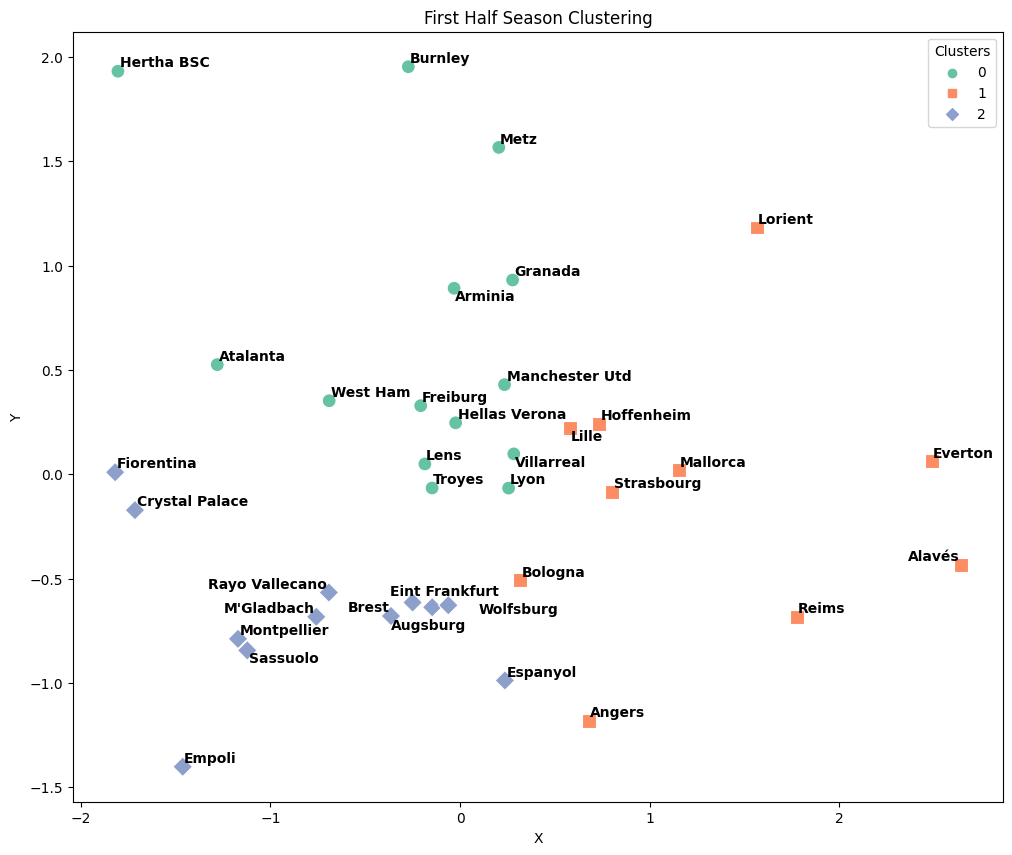

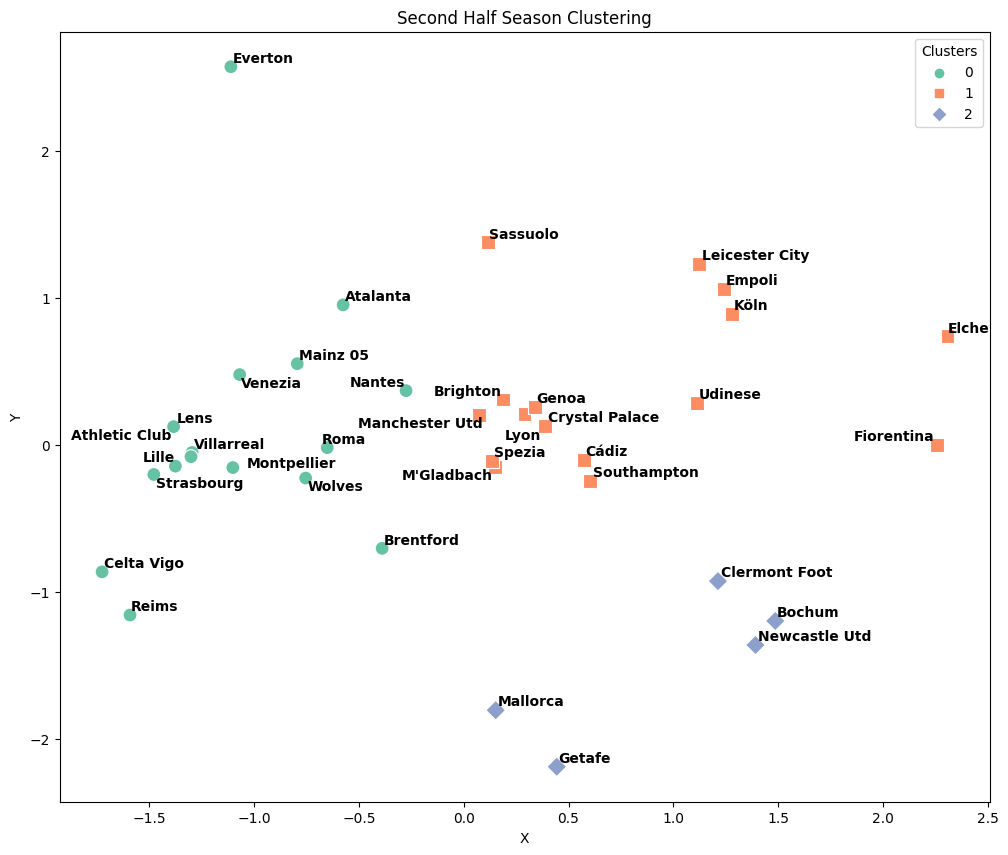

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns

# Load data
df = pd.read_excel('Ranking.xlsx')

# Select numeric variables to use
selected_columns = ['Trend', 'opponent_Trend', 'Nature', 'Home/Away', 'Team_Level', 'attack_score', 'defense_score']

# Apply additional filtering for weak teams winning against strong teams
filtered_df = df[(df['Team_Level'].isin([1, 2, 3])) & (df['opponent_Level'] == 0) & (df['Result'] == 2)]

filtered_df['Nature'] = filtered_df['Nature'].map({'offensive': 0, 'Defensive': 1})

# Filter for first half and second half
first_half_df = filtered_df[filtered_df['Round'] <= 17]
second_half_df = filtered_df[filtered_df['Round'] > 17]

# Function for PCA, K-Means clustering, and visualization
def cluster_and_visualize(data, title):
    # Calculate team averages
    team_averages = data.groupby('Team Name')[selected_columns].mean()
    team_averages = team_averages.replace([np.inf, -np.inf], np.nan).fillna(team_averages.median())

    # PCA dimensionality reduction and K-Means clustering
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(team_averages)
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(pca_data)

    # Convert clustering results to DataFrame
    clustered_data = pd.DataFrame(pca_data, columns=['X', 'Y'])
    clustered_data['Cluster'] = clusters
    clustered_data['Team Name'] = team_averages.index

    # Visualization
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x='X', y='Y', hue='Cluster', data=clustered_data, palette='Set2', s=100, style='Cluster', markers=['o', 's', 'D'])

    # Adjust text properties and add labels
    texts = [plt.text(x, y, name, horizontalalignment='center', size='medium', color='black', weight='semibold')
             for x, y, name in zip(clustered_data['X'], clustered_data['Y'], clustered_data['Team Name'])]

    # Optimize text positions
    adjust_text(texts)

    # Add a title and legend
    plt.title(title)
    plt.legend(title='Clusters')

# Apply clustering and visualization for first half and second half
cluster_and_visualize(first_half_df, "First Half Season Clustering")
cluster_and_visualize(second_half_df, "Second Half Season Clustering")

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Prepare your features and target
X = df[selected_columns].drop('Nature', axis=1)  # Exclude 'Nature' from features
y = df['Nature']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline

models = {
    "MLPClassifier": make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000)),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "LogisticRegression": make_pipeline(StandardScaler(), LogisticRegression()),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

results_encoded = {}

for name, model in models.items():
    model.fit(X_train, y_train_encoded)
    y_pred_encoded = model.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
    precision = precision_score(y_test_encoded, y_pred_encoded, average='binary')
    recall = recall_score(y_test_encoded, y_pred_encoded, average='binary')
    results_encoded[name] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall}

results_df = pd.DataFrame(results_encoded).T  # Transpose to get models as rows
results_df

,Accuracy,Precision,Recall
MLPClassifier,0.689704,0.715190,0.634831
RandomForestClassifier,0.760226,0.785276,0.719101
GradientBoostingClassifier,0.767278,0.819398,0.688202
LogisticRegression,0.545839,0.551515,0.511236
DecisionTreeClassifier,0.755994,0.798046,0.688202
